In [22]:
# Imports 
import numpy as np
import pandas as pd
import pyodbc as db
import matplotlib.pyplot as plt
import os
%matplotlib inline
import requests

# Constants 
stringVAERSDATA     = "VAERSDATA"
stringVAERSSYMPTOMS = "VAERSSYMPTOMS"
stringVAERSVAX      = "VAERSVAX"

# API values 
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc
# https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
apiKeyName  = "IAN_VAERS"
apiKeyId    = "b4nhr0ojmr7cq4envv3a8ofc5"
apiSecret   = "3ry6vfrzt53fl7p0kn8ir8hdnq70aeclapu5abnar08r8fbz5d"

# Column datatypes - need to finish @TODO - getting the following warning when reading in files:
# DtypeWarning: Columns (11,13,15,16,27) have mixed types.Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)
dtype_VAERSDATA = {"VAERS_ID": np.int64, "RECVDATE": np.object, "STATE": np.str, "AGE_YRS": np.float64, "CAGE_YR": np.float64, "CAGE_MO": np.float64, "SEX": np.str, "RPT_VDATE": np.object, "SYMPTOM_TEXT": np.str, "DIED": np.str, "DATEDIED": np.object, "L_THREAD": np.str, "ER_VISIT": np.str}

In [2]:
# Locals 
dfVAERSDATA_Initialized     = False
dfVAERSSYMPTOMS_Initialized = False
dfVAERSVAX_Initialized      = False
directory = '.\AllVAERSDataCSVS'
 
# Iterate over files 
for filename in os.listdir(directory):

    # Create the file name 
    fullFilename = os.path.join(directory, filename)

    # Ensure its a file
    if os.path.isfile(fullFilename):

        # Print the file name to see where it breaks - if needed 
        # print(fullFilename)

        # Overall
        if(fullFilename.__contains__(stringVAERSDATA)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSDATA_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSDATA = pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)

                # Set to init 
                dfVAERSDATA_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSDATA = pd.concat([dfVAERSDATA, pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)], ignore_index=True)
            
        # Symptoms
        elif(fullFilename.__contains__(stringVAERSSYMPTOMS)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSSYMPTOMS_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSSYMPTOMS = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSSYMPTOMS_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSSYMPTOMS = pd.concat([dfVAERSSYMPTOMS, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)

        # Vax
        elif(fullFilename.__contains__(stringVAERSVAX)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSVAX_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSVAX = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSVAX_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSVAX = pd.concat([dfVAERSVAX, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)
        

# Merge the vax with the symptoms tables have duplicates or can 
# have duplicates hence using full outer join. Merging vax and symptoms first.
completeDataFrame = pd.merge(left = dfVAERSVAX, right = dfVAERSSYMPTOMS, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Now merge the data frame into the merged frame 
completeDataFrame = pd.merge(left = completeDataFrame, right = dfVAERSDATA, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Performance notes:
# Takes about 100 seconds on Dell Precision 752 with Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, 2701 Mhz, 4 Core(s), 8 Logical Processor(s)

D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11,13,15,16,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,15,23,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,15,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=inte

In [3]:
# Make a copy so we can leave the original untouched 
workingVaxFrame = completeDataFrame.copy(deep=True)

# Print the frame out for fun - DO NOT DO THIS CAUSE THE FILE IS WAY TOO BIG 
# workingVaxFrame.to_csv("workingVaxFrame.csv")

In [5]:
# Get all the values of the type of vaccine to try and find the covid 
covidFrame = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

print(covidFrame.VAERS_ID.unique().shape[0], covidFrame[covidFrame["DIED"] == "Y"].VAERS_ID.unique().shape[0])

717960 15144


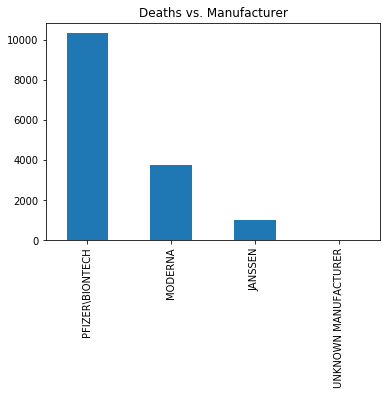

In [20]:
# Get all the deaths 
covidDeathsFrame = covidFrame[covidFrame["DIED"] == "Y"]

# Drop the duplicates which result for multiple vax at same time
covidDeathsFrameNoDupes = covidDeathsFrame.drop_duplicates(subset=["VAERS_ID"])

# Print the data to file 
covidDeathsFrameNoDupes.to_csv("covidDeathsFrameNoDupes.csv")

# Show the bar graph of deaths 
covidDeathsFrameNoDupes["VAX_MANU"].value_counts().plot(kind = "bar", title = "Deaths vs. Manufacturer")

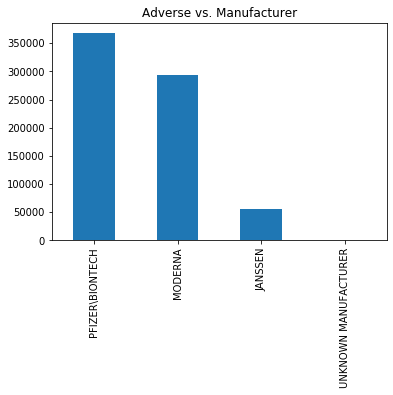

In [21]:
# Drop the duplicates which result for multiple vax at same time
covidFrameNoDupes = covidFrame.drop_duplicates(subset=["VAERS_ID"])

# Plot all the reactions by manufacturer
covidFrameNoDupes["VAX_MANU"].value_counts().plot(kind = "bar", title = "Adverse vs. Manufacturer")